**1. Installing the requirements**

In [1]:
# for mxnet
!pip install --upgrade mxnet
# for pytorch
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

!pip install --upgrade gluoncv

!pip install mxnet-cu101

     |████████████████████████████████| 46.9MB 74kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 154.6MB 54kB/s 
     |████████████████████████████████| 5.1MB 29.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cpu which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 1.1MB 5.8MB/s 
     |████████████████████████████████| 122kB 40.5MB/s 
     |████████████████████████████████| 14.1MB 244kB/s 
     |████████████████████████████████| 317kB 33.7MB/s 
     |█████████████

     |████████████████████████████████| 356.7MB 48kB/s 


**2. Changing the working directory**

In [1]:
# Don't forget to mount the google drive
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


**3. Importing the requirements**

In [2]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

**4. Setting and loading the data**

In [3]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]
# transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66]),
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size = 5
num_workers = 0
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('DataSet/train/'),
                               setting=os.path.expanduser('DataSet/train/train.txt'),
                               slowfast=True,
                               train=True,
                               new_length=64,
                               slow_temporal_stride=16,
                               fast_temporal_stride=2,
                               video_loader=True,
                               use_decord=True,
                               transform=transform_train)

print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 294 training samples.


**5. Loading the model**

In [4]:
net = get_model(name = 'slowfast_4x16_resnet50_custom', nclass = 6)
net.collect_params().reset_ctx(ctx)
print(net)

100%|██████████| 134964/134964 [00:04<00:00, 28839.49KB/s]


SlowFast(
  (fast_conv1): Conv3D(3 -> 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
  (fast_bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
  (fast_relu): Activation(relu)
  (fast_maxpool): MaxPool3D(size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (fast_res2): HybridSequential(
    (0): Bottleneck(
      (conv1): Conv3D(8 -> 8, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (conv2): Conv3D(8 -> 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (conv3): Conv3D(8 -> 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm(axis=1,

**6. Setting up the hyperparameters**

In [5]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [40, 80, 100]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.001, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [7]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [8]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

**7. Trainning**

[Epoch 0] train=0.265306 loss=1.710531 time: 524.743193
[Epoch 1] train=0.646259 loss=1.171237 time: 297.808504
[Epoch 2] train=0.693878 loss=0.746061 time: 301.305857
[Epoch 3] train=0.744898 loss=0.592058 time: 300.259571
[Epoch 4] train=0.819728 loss=0.429817 time: 300.074119
[Epoch 5] train=0.826531 loss=0.428907 time: 307.001795
[Epoch 6] train=0.908163 loss=0.316916 time: 306.871473
[Epoch 7] train=0.918367 loss=0.265872 time: 301.985779
[Epoch 8] train=0.972789 loss=0.166280 time: 300.221640
[Epoch 9] train=0.948980 loss=0.189372 time: 297.485820
[Epoch 10] train=0.962585 loss=0.152463 time: 301.439059
[Epoch 11] train=0.962585 loss=0.139993 time: 298.652070


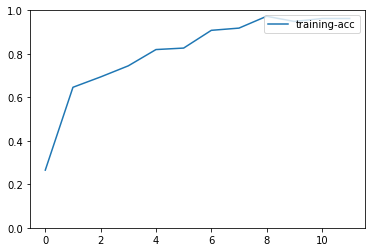

In [9]:
epochs = 12
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()

**8. Saving the model**

In [29]:
net.save_parameters('Model/signof5_slowfast_4x16.params')

**9. Running my infrence**

In [11]:
# Map
CLASS_MAP = {
    0: "Opaque",
    1: "Red",
    2: "Green",
    3: "Yellow",
    4: "Bright",
    5: "Light-blue"
}

In [26]:
from gluoncv.utils.filesystem import try_import_decord
decord = try_import_decord()

video_fname = 'DataSet/train/005_003_001.mp4'
vr = decord.VideoReader(video_fname)
fast_frame_id_list = range(0, 64, 2)
slow_frame_id_list = range(0, 64, 16)
frame_id_list = list(fast_frame_id_list) + list(slow_frame_id_list)
video_data = vr.get_batch(frame_id_list).asnumpy()
clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

# transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_fn = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66]),
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

clip_input = transform_fn(clip_input)
clip_input = np.stack(clip_input, axis=0)
clip_input = clip_input.reshape((-1,) + (36, 3, 224, 224))
clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
print('Video data is readed and preprocessed.')

Video data is readed and preprocessed.


In [27]:
# Running the prediction
pred = net(nd.array(clip_input,  ctx = mx.gpu(0)))
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video clip is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (CLASS_MAP[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video clip is classified to be
	[Bright], with probability 0.445.
	[Opaque], with probability 0.382.
	[Green], with probability 0.083.
	[Red], with probability 0.035.
	[Light-blue], with probability 0.030.
